# Measurement on energy conservation in Compton effect
>for varying angles in 15 $^\circ$ steps
>
>sample: $^{137}$Cs

In [1]:
# %load ../../preamb.py
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys
import re

npy_dir = "./data_npy/"


In [2]:
# %load ../../tools.py
def uc_str(c, max_digit=4):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max max_digit (=4) error digits
    as floats with max 4 error digits
    as exp else
    """
    if c.s == 0 :
        print("You are stupid!")
        raise("error is stupid")
    digit = -int(np.floor(np.log10(np.abs(c.s))))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < (max_digit + 1)): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

def enum(arr1, *args):
    i_range = range(len(arr1))
    return zip(i_range, arr1 ,*args)

def ucarray(X):
    return un.uarray([i.n for i in X],[i.s for i in X])

nom = un.nominal_values
sam = un.std_devs
    


In [42]:
# %load "../../style.py"
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit

sns.set(style='ticks', palette='Set2') 
sns.despine()

# These are the colors. Notice how this is programmed:
# You initialize your colors by 
# colorset = palette()
# then you can cycle through the colors:
# color = next(colorset)
# if you want your set to be reset, just create
# a new palette() instance! This way the colors do not interfere.

color_names = ['windows blue', "pale red", "faded green", "amber", 
          'dark green', 'dark fuchsia', 'browny orange', 
          'puke green', 'dark royal blue', 'dusty purple', 'red orange']
colors = sns.xkcd_palette(color_names)
palette = lambda: itertools.cycle(sns.xkcd_palette(color_names) )

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['legend.markerscale'] = 4
rcParams['axes.titlesize'] = fontsize_labels
rcParams['text.color'] = "0.3"
rcParams['xtick.color'] = "0.3"
rcParams['ytick.color'] = "0.3"
rcParams['axes.labelcolor'] = "0.3"
rcParams['axes.edgecolor'] = "0.8"

xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  

save_fig = True
if not save_fig:
        rcParams['figure.figsize'] = (13, 8) 
fig_dir = "./figures/"  # directory of figures
pres_dir = "../presentation/"

def fixticks(ax):    
    for t in ax.xaxis.get_ticklines(): t.set_color('0.8')
    for t in ax.yaxis.get_ticklines(): t.set_color('0.8')


In [4]:
# %load "../../preamb.py"
import numpy as np
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter as sav
from scipy.special import erfc
from scipy.integrate import quad
import sys

npy_dir = "./data_npy/"


In [5]:
data_dir = './data/'
show_fig = True

## Functions

In [6]:
def linear(x, a, b):
    return (a*x + b)

def gauss0(x, *p):
    A, mu, sigma = p
    return  A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

def gauss(x, *p):
    A, mu, sigma, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) + offset

def gauss_times_exp(x, *p):
    A, mu, sigma, C, lamb, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) * \
            C * np.exp(lamb * (x - x_min)) + \
            offset

def gauss_line(x, *p):
    # gauss plus straight line m*(x - mu) + offset
    A, mu, sigma, m, offset= p
    return  A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2)) + \
            m * (x - mu) + offset

import scipy as sc
norm = sc.stats.norm

# PS scintillator

## $^{137}$Cs Sample at various angles, PS (electrons)

## Background and random coincidences

In [7]:
#### Background ####
file_name = "coin_ps_background"
file_in = npy_dir + file_name + '.npy'
x_bg, y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1,np.sqrt(y_bg)))

t_bg = 48378.091
print(t_bg/3600)

rate_bg = y_bg / t_bg
y_bg = rate_bg
y_bg_fil = sav(y_bg, 201, 7)# filtered
rate_bg_e = y_bg_e / t_bg

13.438358611111111


In [8]:
#### Random coincidences ####
file_name = "coin_ps_random"
file_in = npy_dir + file_name + '.npy'
x_rnd, y_rnd = np.load(file_in)
y_rnd_e = un.uarray(y_rnd, np.maximum(1, np.sqrt(y_rnd)))

t = 3600.000 
rate_rnd = y_rnd / t
y_rnd = rate_rnd
rate_rnd_e = y_rnd_e / t

ps_cal = np.load(npy_dir + 'ps_calibration.npy')

/usr/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


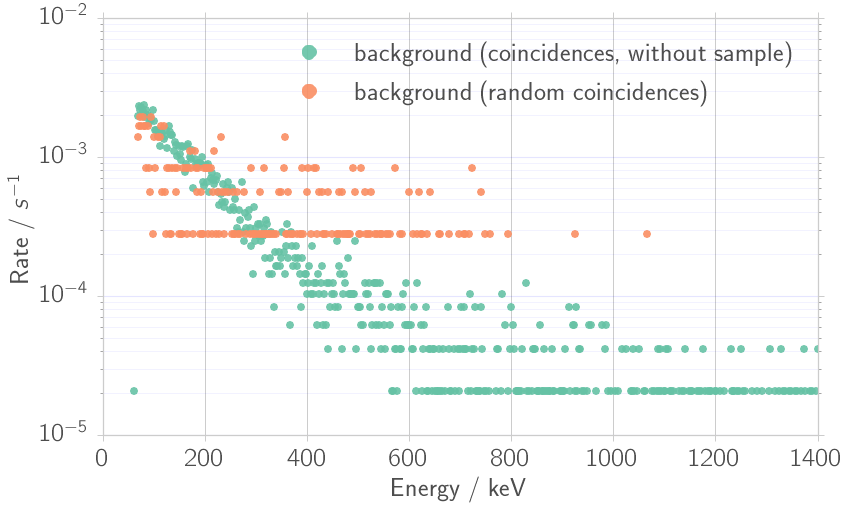

In [9]:
# Plotting
savefig = True
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Histogram PS, coincident")
ax1.plot(nom(linear(x_bg, *ps_cal)), rate_bg, '.', alpha=0.9, label='background (coincidences, without sample)',markersize = 15)
ax1.plot(nom(linear(x_rnd, *ps_cal)), rate_rnd, '.', alpha=0.9, label='background (random coincidences)',markersize = 15)
ax1.set_xlabel("Energy / keV")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1400)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1,markerscale = 2)
ax1.grid(True)
ax1.set_yscale("log", nonposy='clip')

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)


if show_fig:
    fig1.show()
if save_fig:
    file_name = "coin_background_random"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


# Rebinning might have to be redone - fits dont converge and errors might not be propagated correctly!

In [10]:
# %load fit_n_plot_ps.py
def fit_n_plot_ps(theta, fit_boundaries, p0, fit=True):
    save_fig=True
    '''
    Fits coincident electrons from PVC scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    rate_bg, rate_rnd, show_fig, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_ps_" + str(theta)
    file_in = npy_dir + file_name + '.npy'
    x, y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.mcd'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[5].split()[1]) # livetime is written in line 5...
    print(t/3600)
    rate = y / t
    rate = rate - rate_bg
    rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!
    rate_e = y_e / t - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = un.std_devs(rate_e[mask])
    if fit:
        coeff, cov = curve_fit(gauss, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)
        fit_peak = gauss(x_fit, *coeff)
        #x_c = coeff[1]
        c = uc.correlated_values(coeff, cov)
    else:
        fit_peak = gauss(x_fit, *p0)      # visualize initial guess
        c = 0

    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        if not save_fig:
            fig1.suptitle("PVC scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(nom(linear(x, *ps_cal)), y, '.', alpha=0.9, label='Data for $%i^\circ$'%theta)
        fixticks(ax1)
        peak, = ax1.plot(nom(linear(x_fit, *ps_cal)), fit_peak, '-', alpha=0.8, \
                         label='Least squares fit',linewidth=5)
        #ax1.plot([x_c] * 2, [0, max(y)*1.5], '--', c=peak.get_color(), label='peak')
        
        ax1.plot(nom(linear(x_bg, *ps_cal)), y_bg, '.', alpha=0.9, label='background')
        ax1.plot(nom(linear(x_rnd, *ps_cal)), y_rnd, '.', alpha=0.9, label='random coincidences')
        #ax1.plot(x_bg, y_bg_fil, '-', alpha=0.9, label='bg filtered')
        
        ax1.set_xlabel("Energy / keV")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(70, 1000)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)

0.5
0.5
1.0
1.0
1.0
1.0
1.0176844444444446
0.5


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


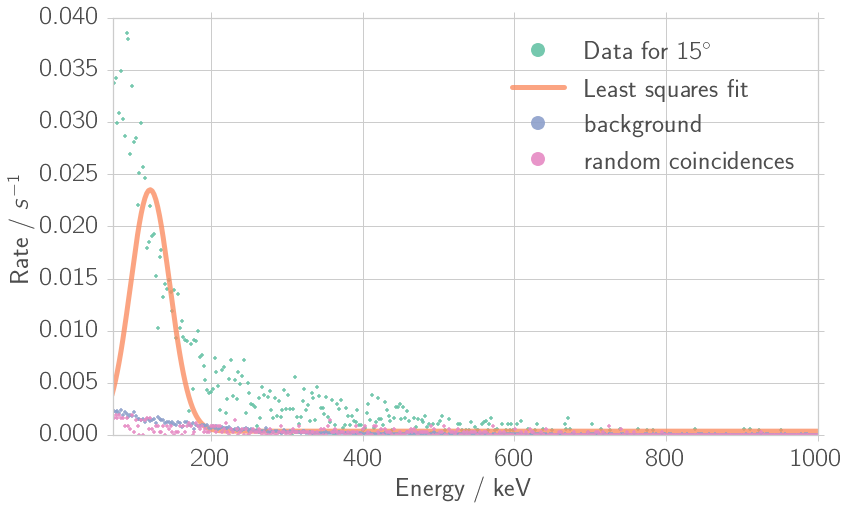

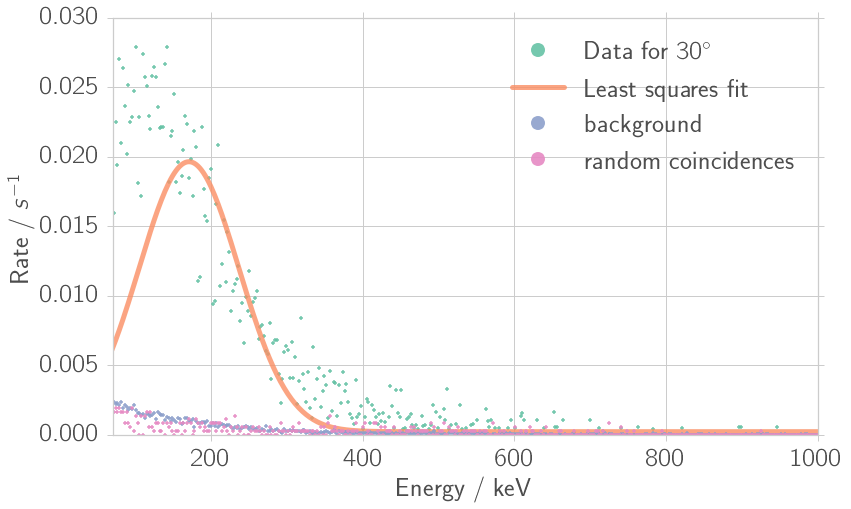

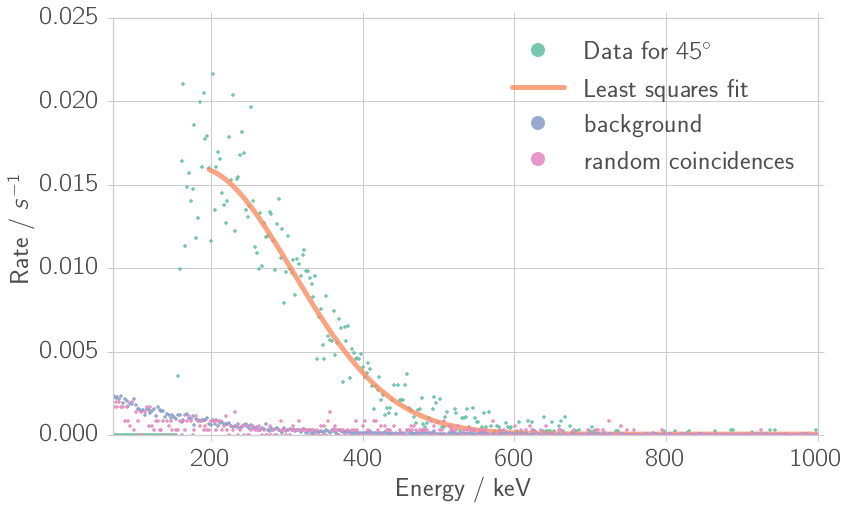

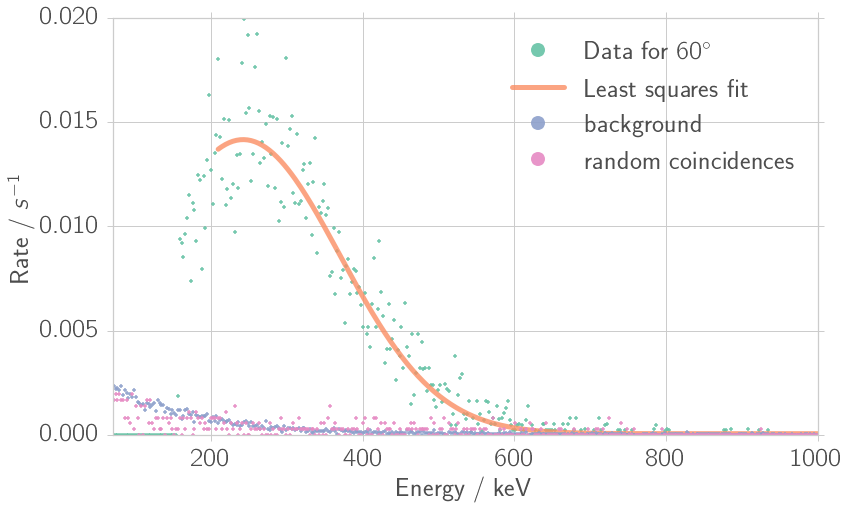

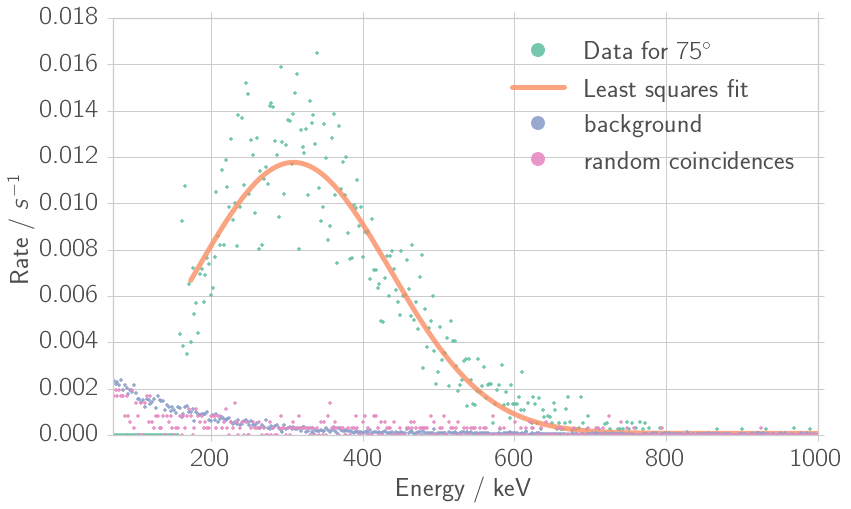

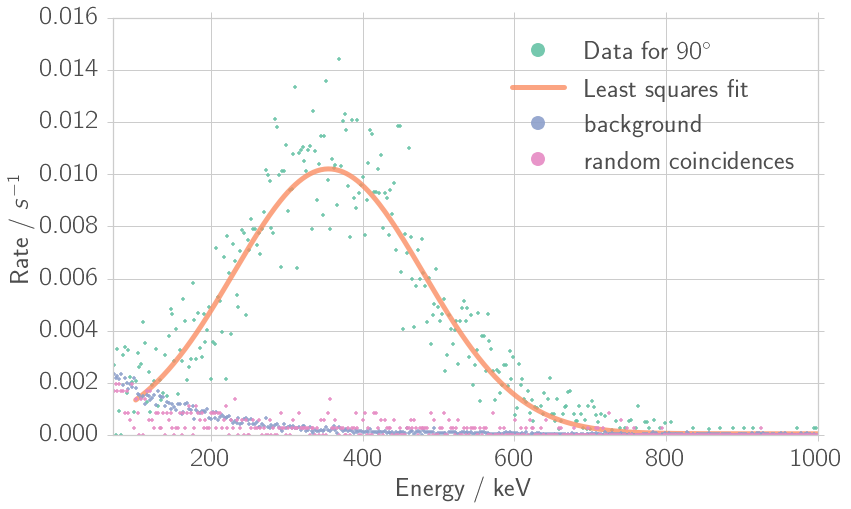

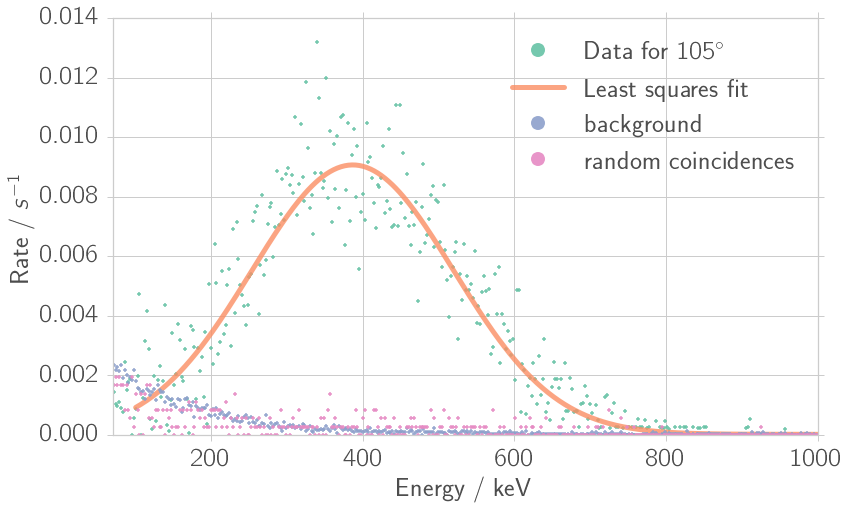

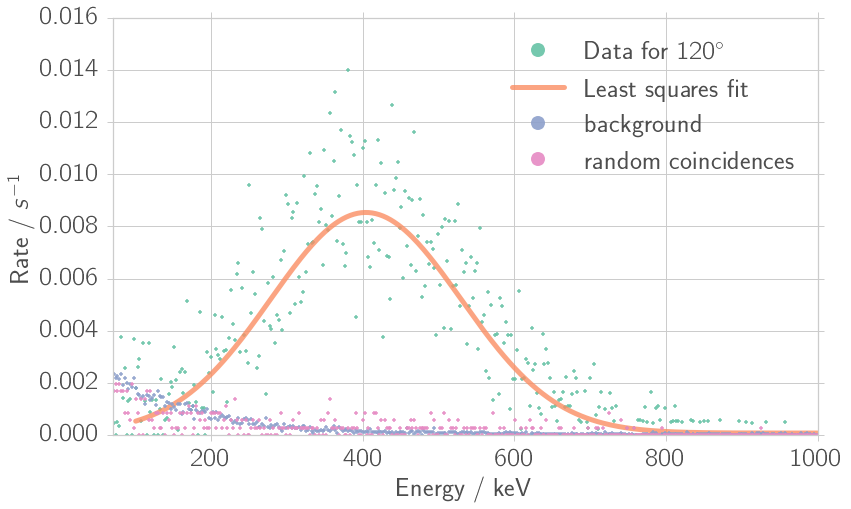

In [11]:
c_ps_gauss = []
theta_ps = [15, 30, 45, 60, 75, 90, 105, 120]
fit_boundaries = [[0, 400],[5, 400], [60, 500], [65, 400],
                  [50, 400], [20, 500], [20, 500], [20, 500]]
p0 = [[1.5e-2, 5, 40, 0],
      [2e-2, 44, 60, 0], 
      [0.01, 80, 40, 0],
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0], 
      [0.01, 100, 50, 0],
      [0.01, 100, 50, 0]]

show_fig = True

for params in zip(theta_ps, fit_boundaries, p0):
    #if i[0] == 45:
    #    c = (fit_n_plot_ps(*i, fit=True))
    #    print(c)  
    c_ps_gauss.append(fit_n_plot_ps(*params, fit=True))
show_fig = True

In [12]:
# %load fit_n_plot_ps.py
def filter_n_plot_ps(theta, fit_boundaries, p0, fit=True):
    save_fig = True

    #### GET DATA  ####
    file_name = "coin_ps_" + str(theta)
    file_in = npy_dir + file_name + '.npy'
    x, y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))
    ### Get time from file
    file_in_mcd = data_dir + file_name + '.mcd'
    f = open(file_in_mcd)
    settings = f.read()
    f.close()
    lines = settings.split('\n')
    t = np.float(lines[5].split()[1]) # livetime is written in line 5...
    print(t/3600)
    rate = y / t
    rate = rate - rate_bg
    rate = rate - rate_rnd
    rate[rate < 0] = 0
    y = rate    # Continue to work with the rate!
    rate_e = y_e / t - rate_bg_e - rate_rnd_e
    rate_e[rate < 0] = 0 
    y_filtered2 = sav(y[10::], 81, 4)
    
    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            fig1.suptitle("PVC scintillator, coincident; angle: %i$^\circ$"%theta)
        ax1.plot(nom(linear(x, *ps_cal)), y, '.', alpha=0.9, label='Data')
        ax1.plot(nom(linear(x[10::], *ps_cal)), y_filtered2, '-', alpha=0.9, label='Filtered data',linewidth=5)
        
        ax1.plot(nom(linear(x_bg, *ps_cal)), y_bg, '.', alpha=0.9, label='background')
        ax1.plot(nom(linear(x_rnd, *ps_cal)), y_rnd, '.', alpha=0.9, label='random coincidences')
        
        ax1.set_xlabel("Energy / keV")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(70, 1000)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        if save_fig:
            fig1.savefig(fig_dir + file_name +"_filter_"+ ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")
    channels = x[10::]
    max_channel = np.argmax(y_filtered2)
    val_at_std = np.max(y_filtered2)*0.9
    max_channel_std = np.max(np.abs(((channels - max_channel)[val_at_std < y_filtered2])))
    chu = uc.ufloat(max_channel,max_channel_std+1)
    return(chu)

0.5
0.5
1.0
1.0
1.0
1.0
1.0176844444444446
0.5


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


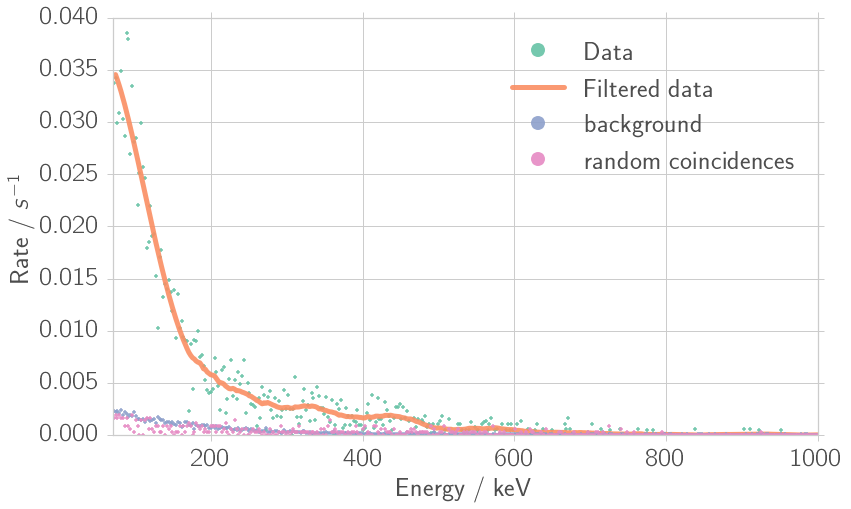

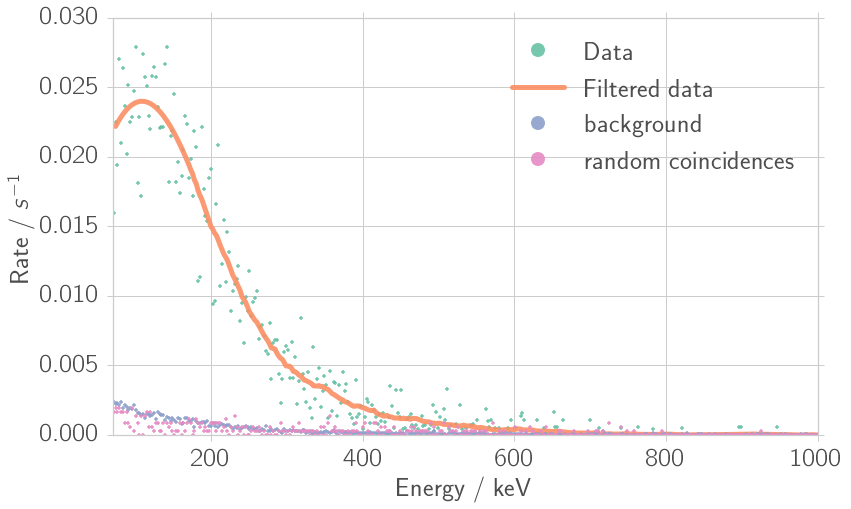

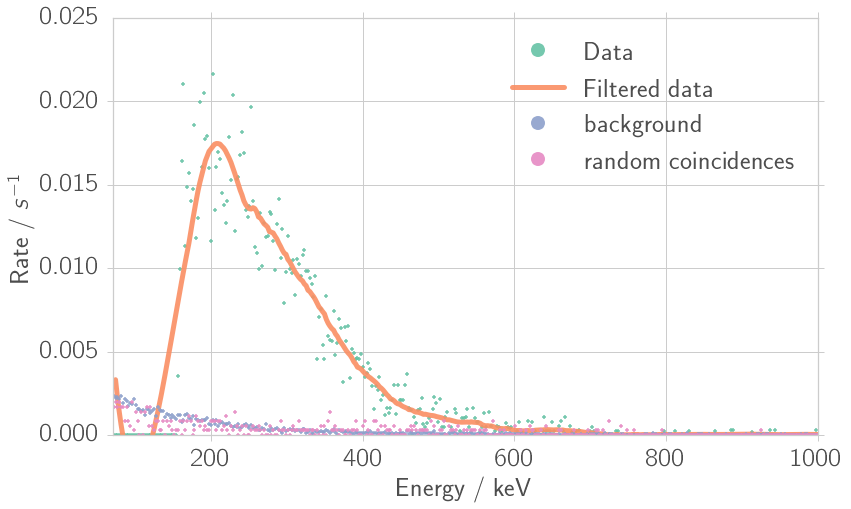

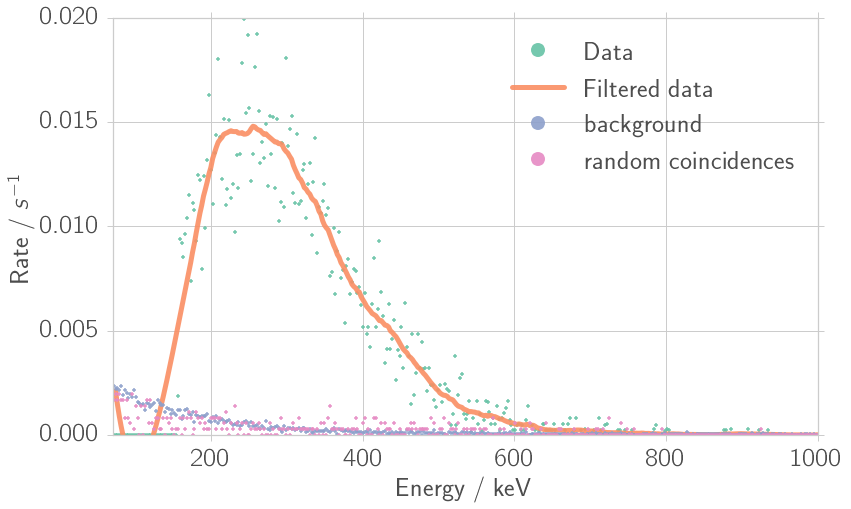

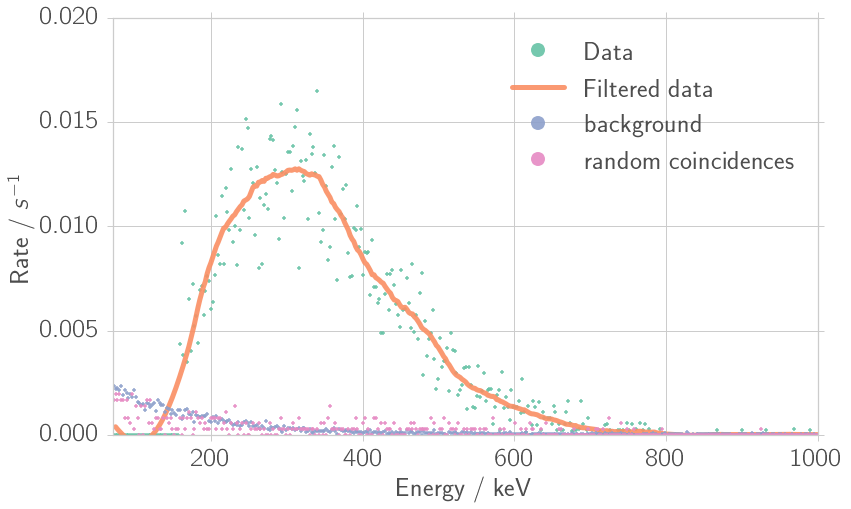

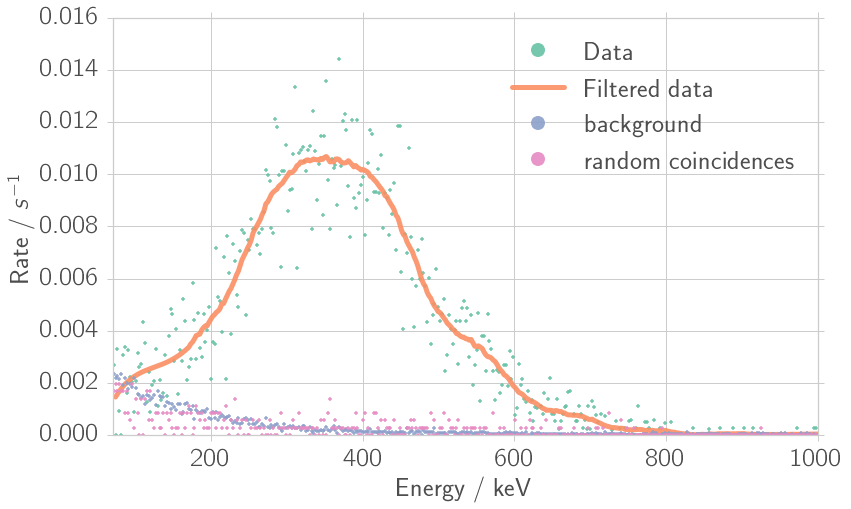

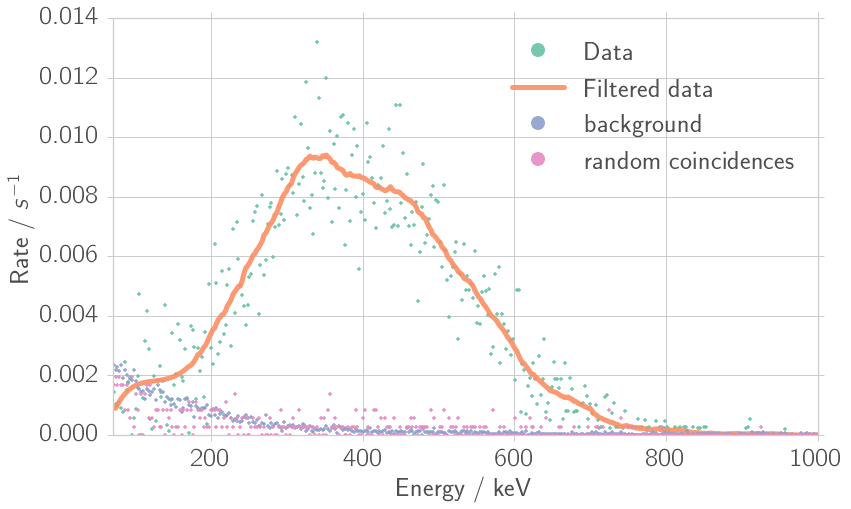

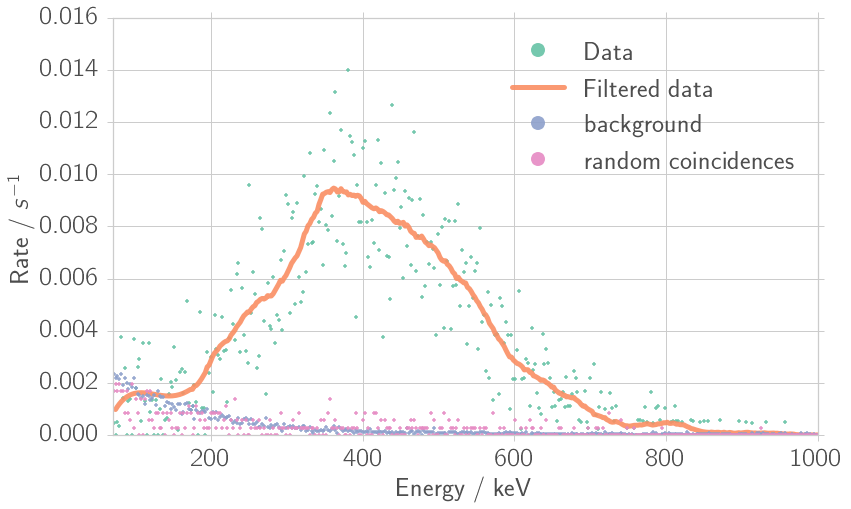

In [13]:
show_fig = True
c_ps_filter = []
for i in zip(theta_ps, fit_boundaries, p0):
    c_ps_filter += [(0,filter_n_plot_ps(*i))]

#NaI (photons)

## $^{137}$Cs Sample at various angles, NaI (photons)

In [14]:
def rebin(y):
    # Rebinning: 1/16 of number of bins
    z = y[:-13] # last 13 bins are dropped to obtain a len(z) as a multiple of 16
    z = z.reshape([len(z) / 16, 16])
    z = np.sum(z, axis=1)
    return z

def get_rates(file_name):
    # get data
    file_in = npy_dir + file_name + '.npy'
    print(file_in)
    y = np.load(file_in)
    y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))      
    # get time
    file_in_mcd = data_dir + file_name + '.TKA'
    f = open(file_in_mcd)
    settings = f.readlines()
    f.close()
    t = np.float(settings[1])   # livetime is written in line 1...
    print('measurement time in h: ', t/3600)
    y_e = y_e / t      # counts to rates
    return  y_e


./data_npy/coin_na_background.npy
measurement time in h:  62.000277777777775


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


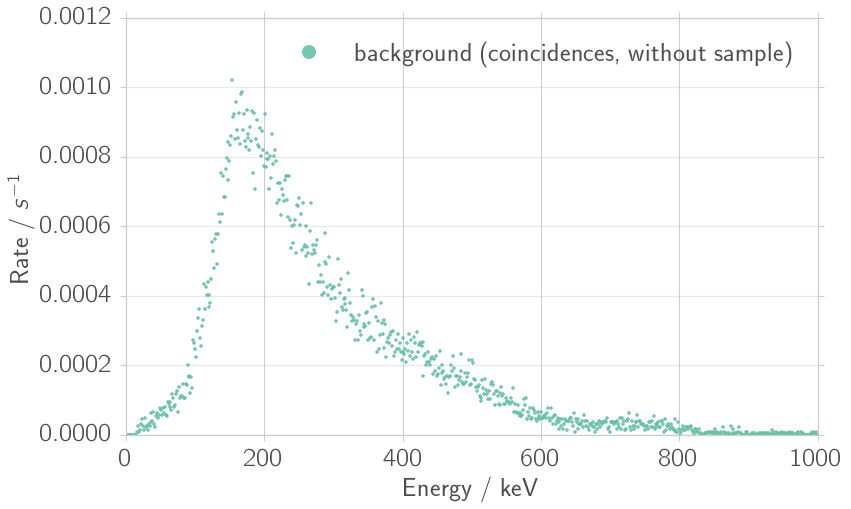

In [28]:
#### Background ####
save_fig = True
file_name = "coin_na_background"
y_bg_e = get_rates(file_name)
y_bg_e = rebin(y_bg_e)      # Rebinning: 1/16 of number of bins
y_bg = nom(y_bg_e)          # nominal values
y_bg_fil = sav(y_bg, 201, 7)# filtered
x_bg = np.arange(len(y_bg)) # channel

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle("Histogram NaI, coincident")
ax1.plot(nom(linear(16 * x_bg, *na_cal)), y_bg, '.', alpha=0.9, label='background (coincidences, without sample)')
#ax1.plot(x_bg, y_bg_fil, '-', alpha=0.9, label='bg filtered')
ax1.set_xlabel("Energy / keV")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')

ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.1)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.1)
ax1.xaxis.grid(True)

if save_fig:
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


./data_npy/coin_na_random.npy
measurement time in h:  1.0
./data_npy/coin_na_0.npy
measurement time in h:  0.5
./data_npy/na_total_incident.npy
measurement time in h:  1.006388888888889


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


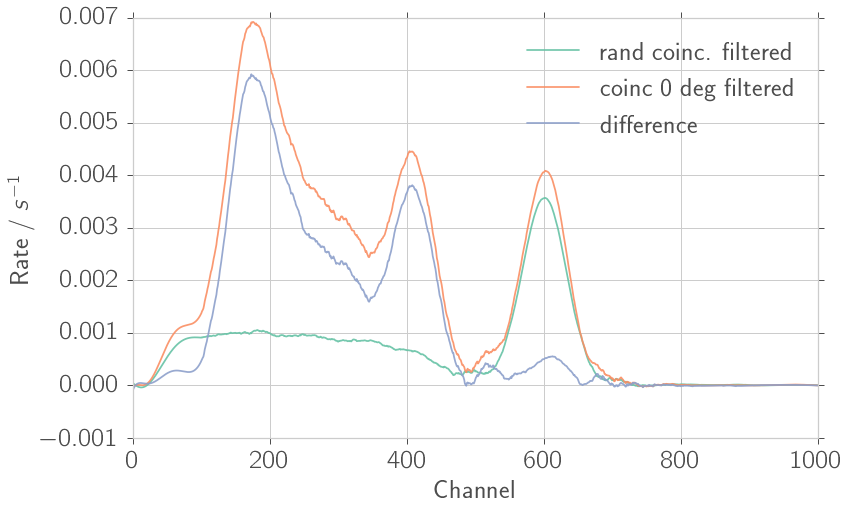

In [16]:
#### Random coincidences ####
file_name = "coin_na_random"
y_rnd_e = get_rates(file_name)
y_rnd_e = rebin(y_rnd_e)      # Rebinning: 1/16 of number of bins
y_rnd = nom(y_rnd_e)          # nominal values
y_rnd_fil = sav(y_rnd, 201, 7)# filtered
x_rnd = np.arange(len(y_rnd)) # channel

#### Data at zero degrees:
file_name = "coin_na_0"
y0_e = get_rates(file_name)
y0_e = rebin(y0_e)      # Rebinning: 1/16 of number of bins
y0_e = y0_e - y_bg_e    # minus background (already rebinned)
y0_e[nom(y0_e) < 0] = uc.ufloat(0, min(sam(y0_e)[sam(y0_e)>0])) # errors != 0 
y0 = nom(y0_e)          # nominal values
y0_fil = sav(y0, 201, 7)# filtered
x0 = np.arange(len(y_rnd)) # channel

#### Data at zero degrees without PVC:
file_name = "na_total_incident"
y_e = get_rates(file_name)
y_e = rebin(y_e)        # Rebinning: 1/16 of number of bins
y_e = y_e - y_bg_e    # minus background (already rebinned)
#y_e = y_e - y_rnd_e    # minus random coincidences (already rebinned)
y_e[nom(y_e) < 0] = uc.ufloat(0, min(sam(y_e)[sam(y_e)>0])) # errors != 0 
y = nom(y_e)            # nominal values
y_fil = sav(y, 201, 7)  # filtered
x = np.arange(len(y_e)) # channels
factor = 4e-4

# Plotting
fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle("Histogram NaI, coincident")
#ax1.plot(x_rnd, y_rnd, '.', alpha=0.9, label='random coincidences')
ax1.plot(x_rnd, y_rnd_fil, '-', alpha=0.9, label='rand coinc. filtered')
#ax1.plot(x0, y0, '.', alpha=0.9, label='coincident 0 deg')
ax1.plot(x0, y0_fil, '-', alpha=0.9, label='coinc 0 deg filtered')
ax1.plot(x0, y0_fil - y_rnd_fil, '-', alpha=0.9, label='difference')
#ax1.plot(x, y*factor, '.', alpha=0.9, label='full incident')
#ax1.plot(x, y_fil*factor, '-', alpha=0.9, label='filtered')
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(0, 0.025)
ax1.legend(loc=1)
ax1.grid(True)
#ax1.set_yscale("log", nonposy='clip')

if save_fig:
    fig1.savefig(fig_dir + "random_coin_na.pdf")
    fig1.savefig(fig_dir + "random_coin_na.png")       


# New approach: Gauss + $c Exp[-bt]$  for noise!

./data_npy/coin_na_15.npy
measurement time in h:  0.5
[0.0+/-0.0022222944830891725 0.0+/-0.002222294483089173
 0.0+/-0.0022222944830891725 ..., 0.0+/-0.002222294483089172
 0.0+/-0.0022222944830891725 0.0+/-0.0022222944830891725]


/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


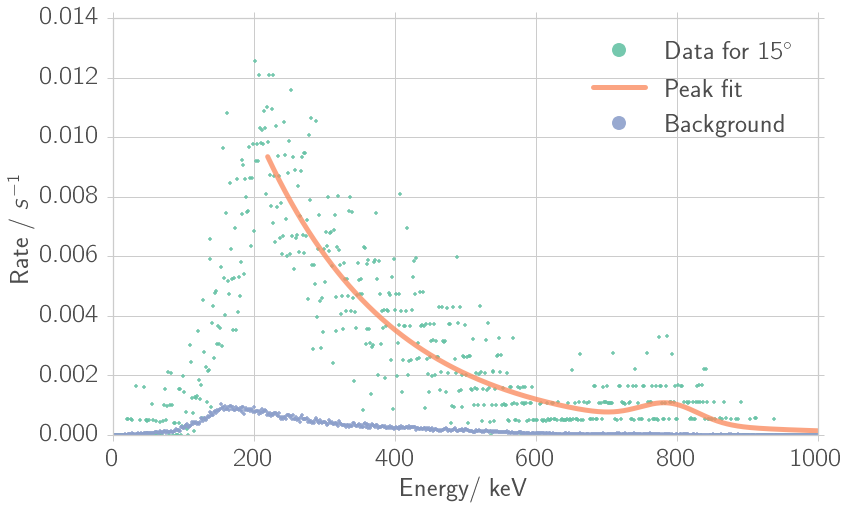

In [17]:
def gauss_noise(x, *p):
    A, mu, sigma,b,c = p
    return  c*np.exp(- b*x) + A / (np.sqrt((2 * np.pi)) * sigma) * np.exp(-(x - mu)**2 / (2. * sigma**2))

na_cal = np.load(npy_dir + 'na_calibration.npy')

def fit_n_plot_na(theta, fit_boundaries, p0, fit=True):


    '''
    Fits coincident photons from NaI scintillator
    - measured at theta (in degress)
    - fit range: fit_boundaries = [x_min, x_max] 
    - initial guess: p0  = [A, x_peak, sigma, offset]
    
    Needs global variables:
    y_bg, y_rnd, save_fig

    Uses gauss plus offset for fit.
    Needs background and random coincidences to be defined
    globally as rate_bg and rate_rnd, respectively   
    Further plots the result.
    Saves to pdf and png if specified.
    Returns coefficients as correlated variables c
    (use uc.covariance_matrix to obtain covariance matrix!).
    '''
    #### GET DATA  ####
    file_name = "coin_na_" + str(theta)
    y_e = get_rates(file_name)
    y_e = rebin(y_e)        # Rebinning: 1/16 of number of bins
    y_e = y_e - y_bg_e    # minus background (already rebinned)
    #y_e = y_e - y_rnd_e    # minus random coincidences (already rebinned)
    y_e[nom(y_e) < 0] = uc.ufloat(0,min(sam(y_e)[sam(y_e)>0]))
    print(y_e)
    # set values smaller zero to zero. NOT A GOOD IDEA! ERROR IS ZERO THEN! DIRTY HARRY HACK
    y = nom(y_e)            # nominal values
    y_fil = sav(y, 201, 7)  # filtered
    x = np.arange(len(y_e)) # channels
    
    np.save(npy_dir + 'na_rate_' + str(theta), y_e)

    ###### FIT PEAK #################
    x_min, x_max = fit_boundaries
    mask = (x >x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = un.std_devs(y_e[mask])
    if fit:
        try:
            coeff, cov = curve_fit(gauss_noise, x_fit, y_fit, p0=p0,
                sigma=y_sigma, absolute_sigma=True)
            
            #coeff, cov = curve_fit(gauss_noise, x_fit, y_fit, p0=p0)
               
            fit_peak = gauss_noise(x_fit, *coeff)
            #x_c = coeff[1]
            c = uc.correlated_values(coeff, cov)
        except:
            print("fit did not converge... estimating paramters")
            fit_peak = gauss_noise(x_fit, *p0)
            c = un.uarray(p0,np.abs(p0)/10)
    else:
        fit_peak = gauss_noise(x_fit, *p0)      # visualize initial guess
        c = un.uarray(p0,np.abs(p0)/10)
    np.save(npy_dir + 'i_photon_' + str(theta), c[0])
    
    ###### PLOTTING #################
    if show_fig:
        fig1, ax1 = plt.subplots(1, 1)
        fixticks(ax1)
        if not save_fig:
            fig1.suptitle("NaI scintillator, coincident; angle: %i$^\circ$"%theta)
            
            
        ax1.plot(nom(linear(16 * x, *na_cal)), y, '.', alpha=0.9, label='Data for $%i^\circ$'%theta)
        
        #ax1.fill_between(nom(linear(16 * x, *na_cal)), y + sam(y_e), y - sam(y_e),\
         #   facecolor=colors[0], color=colors[0], alpha=0.2)
        
        #ax1.plot(x, y_fil, '-', alpha=0.9, label='Filtered data')
        ax1.plot(nom(linear(16 * x_fit, *na_cal)), fit_peak, '-', alpha=0.8, label='Peak fit',linewidth=5)
        
        ax1.plot(nom(linear(16 * x_bg, *na_cal)), y_bg, '.', alpha=0.9, label='Background')
        #ax1.plot(x_bg, y_bg_fil, '-', alpha=0.9, label='bg filtered')
        
        ax1.set_xlabel("Energy/ keV")
        ax1.set_ylabel("Rate / $s^{-1}$")
        ax1.set_xlim(0, 1000)
        ax1.set_ylim(0,)
        ax1.legend(loc=1)
        ax1.grid(True)
        savefig = False
        if save_fig:
            fig1.savefig(fig_dir + file_name + ".pdf")
            fig1.savefig(fig_dir + file_name + ".png")

    return(c)

# Test run
theta_na = [15] # data for 0 is not usable...
fit_boundaries = [[180, 800]]

p0 = [[0.2, 560, 60,0.01,0.07]]

show_fig = True
for i, paramter in enumerate(zip(theta_na,fit_boundaries, p0)):
    if i == 0:
        fit_n_plot_na(*paramter, fit=True)
show_fig = True

./data_npy/coin_na_15.npy
measurement time in h:  0.5
[0.0+/-0.002222294483089173 0.0+/-0.002222294483089173
 0.0+/-0.002222294483089173 ..., 0.0+/-0.002222294483089172
 0.0+/-0.0022222944830891725 0.0+/-0.0022222944830891725]
./data_npy/coin_na_30.npy
measurement time in h:  0.5
[0.0+/-0.0022222944830891725 0.0+/-0.0022222944830891725
 0.0+/-0.0022222944830891725 ..., 0.0+/-0.002222294483089172
 0.0+/-0.002222294483089172 0.0+/-0.0022222944830891725]
./data_npy/coin_na_45.npy
measurement time in h:  1.0
[0.0+/-0.0011112556257967237 0.0+/-0.0011112556257967235
 0.0+/-0.0011112556257967237 ..., 0.0+/-0.0011112556257967235
 0.0+/-0.0011112556257967237 0.0+/-0.001111255625796724]
./data_npy/coin_na_60.npy
measurement time in h:  1.0
[0.0+/-0.001111255625796724 0.0+/-0.0011112556257967237
 0.0+/-0.0011112556257967237 ..., 0.0+/-0.0011112556257967235
 0.0+/-0.0011112556257967237 0.0+/-0.0011112556257967235]
./data_npy/coin_na_75.npy
measurement time in h:  1.0
[0.0+/-0.001111255625796724 0.

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


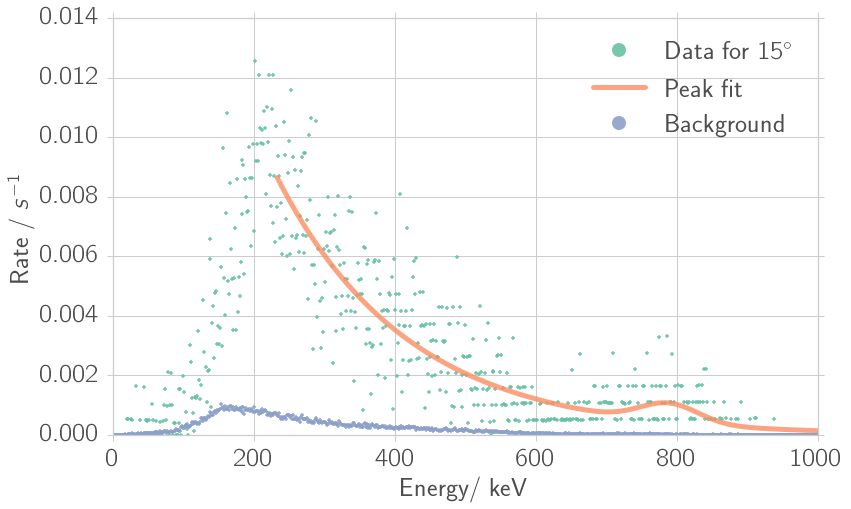

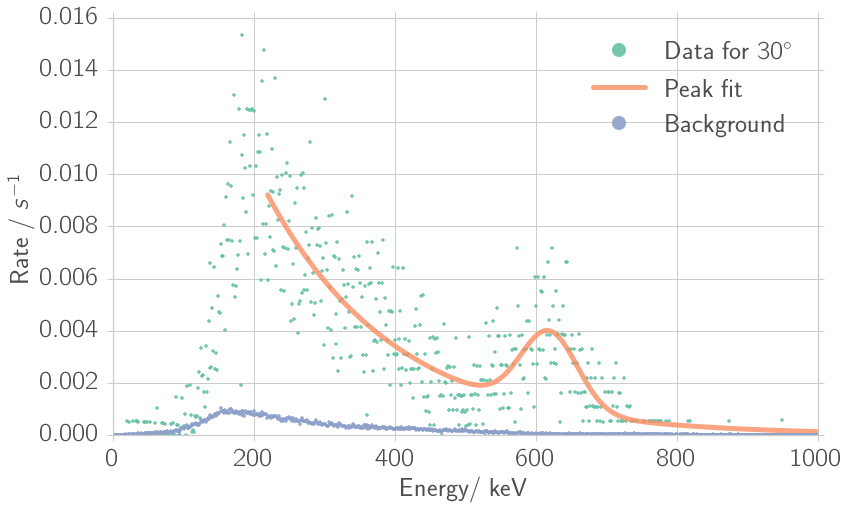

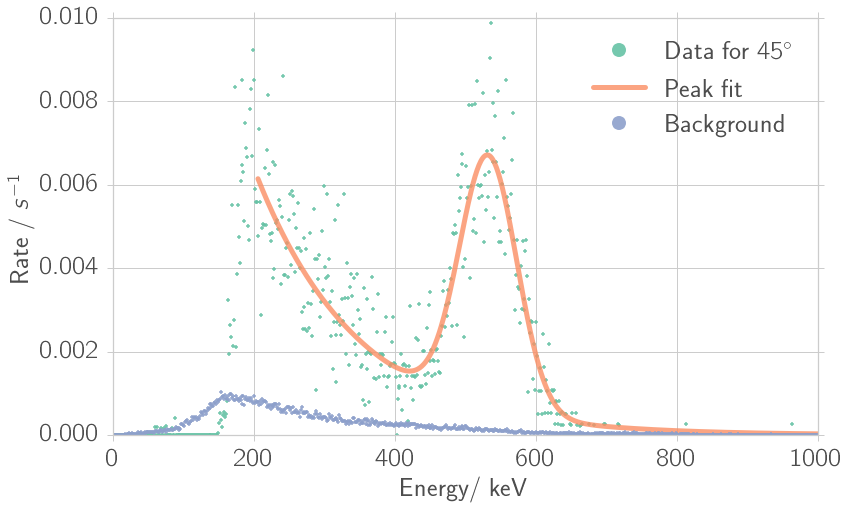

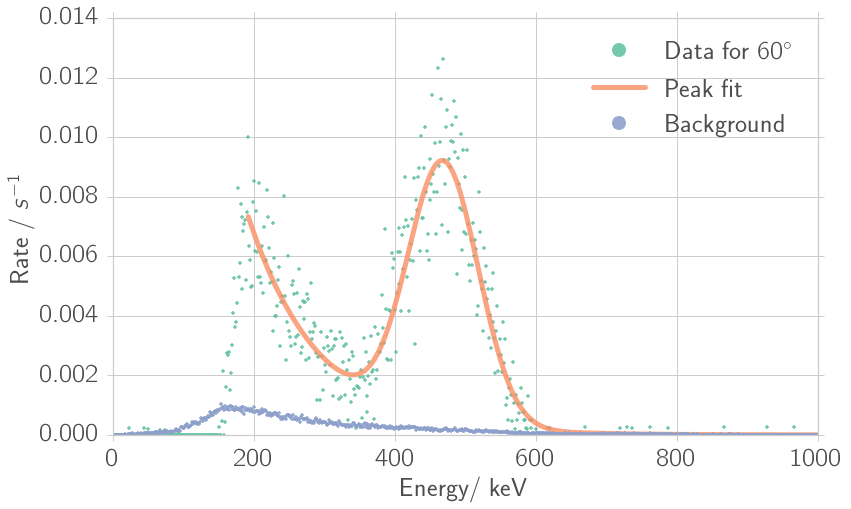

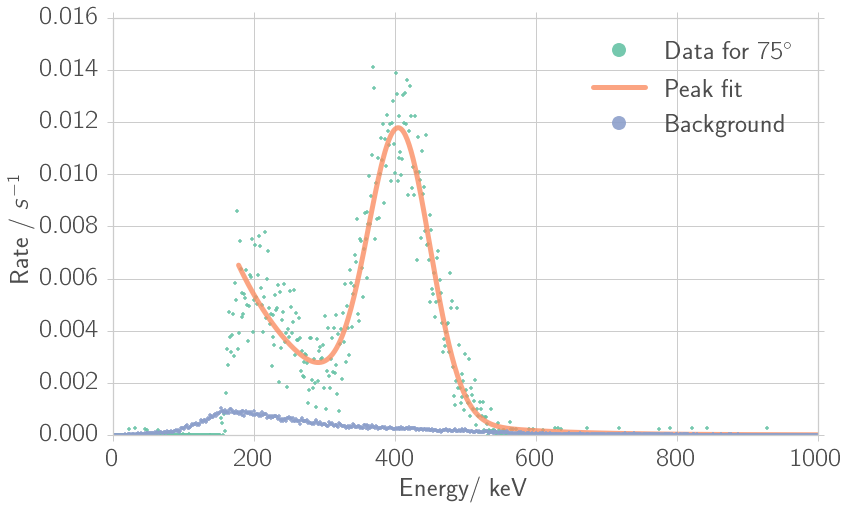

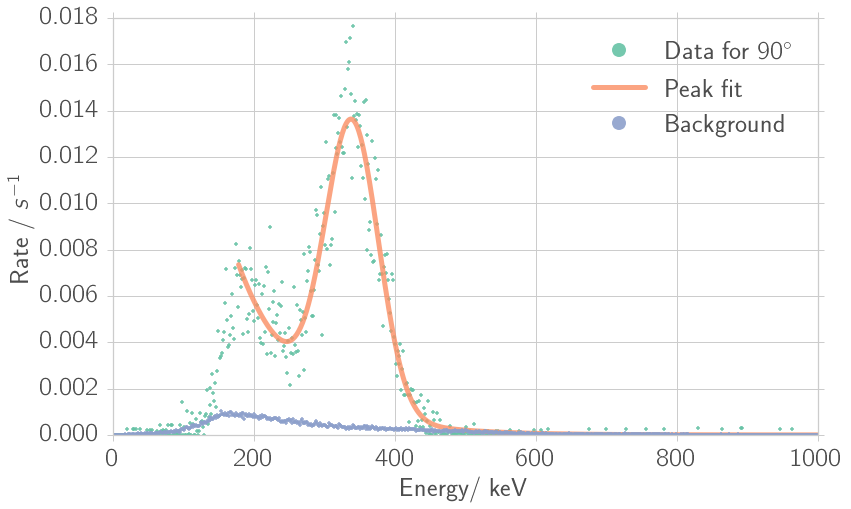

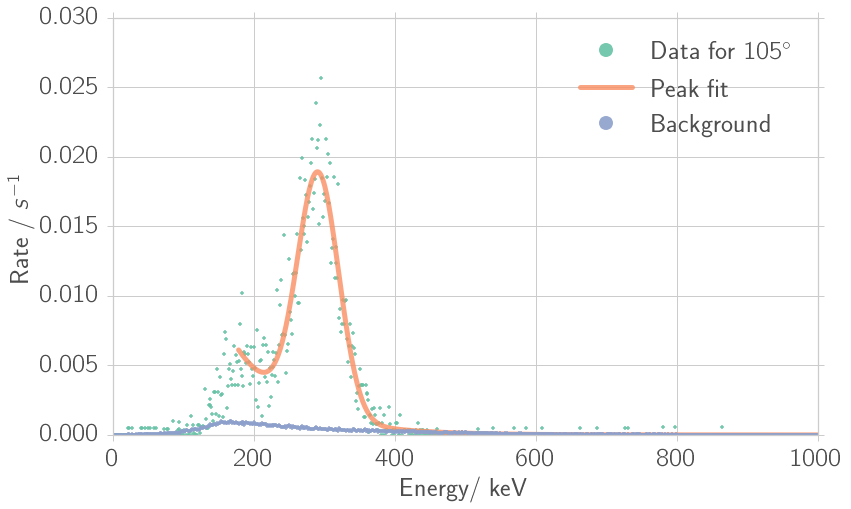

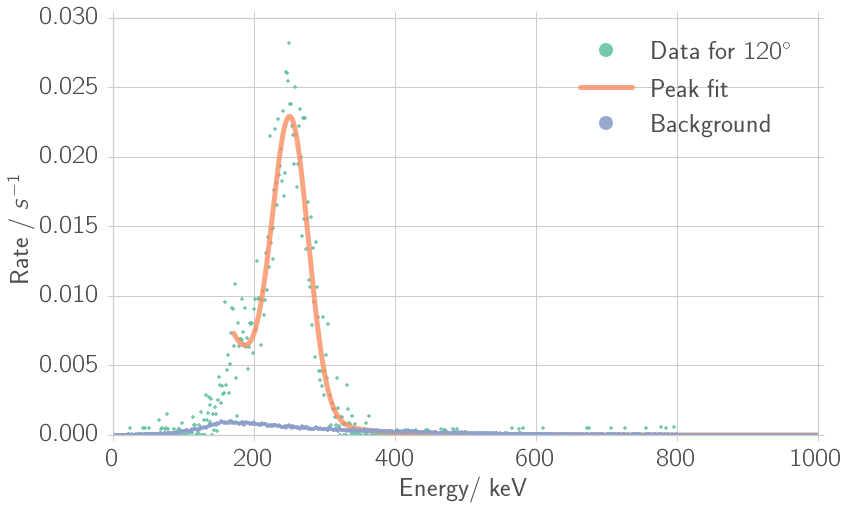

In [18]:
c_na = []
theta_na = [15, 30, 45, 60, 75, 90, 105, 120] # data for 0 is not usable...
fit_boundaries = [[190, 800], [180, 800], [170, 800], [160, 800], 
                  [150, 800], [150, 800], [150, 800], [145, 800]]

p0 = [[0.2, 560, 60,0.01,0.06],
      [0.5, 480, 40,0.01,0.06],
      [0.6, 400, 40,0.01,0.05], 
      [0.9, 370, 30,0.01,0.04], 
      [1.1, 320, 30,0.01,0.04],
      [1.2, 280, 30,0.01,0.04],
      [1.1, 220, 30,0.02,0.04],
      [1.1, 220, 30,0.02,0.04]]

show_fig = True
for i in zip(theta_na,fit_boundaries, p0):
    c_na.append(fit_n_plot_na(*i, fit=True))
show_fig = True
#correct error of first
c_na = np.array(c_na)
c_na[0][1] = uc.ufloat(c_na[0][1].n, 100)

In [19]:
c_na[0][1] = uc.ufloat(c_na[0][1].n-80, 200)

# Plot energy conservation

## Channel to energy

##II: This time we do not use the first four figures for fitting, instead we estimate their maximum by filtering.

In [20]:
def E_red(E_gamma):
    from scipy.constants import physical_constants as pc
    m_e = pc["electron mass energy equivalent in MeV"][0] * 10**3 # in keV
    return(E_gamma / m_e)
    
def E_photon(theta_deg, E_gamma):
    theta = theta_deg * np.pi / 180
    b = E_red(E_gamma) * (1 - np.cos(theta))
    return E_gamma / (1 + b) 

def E_electron(theta_deg, E_gamma):
    theta = theta_deg * np.pi / 180
    b = E_red(E_gamma) * (1 - np.cos(theta))
    return E_gamma * b / (1 + b)

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


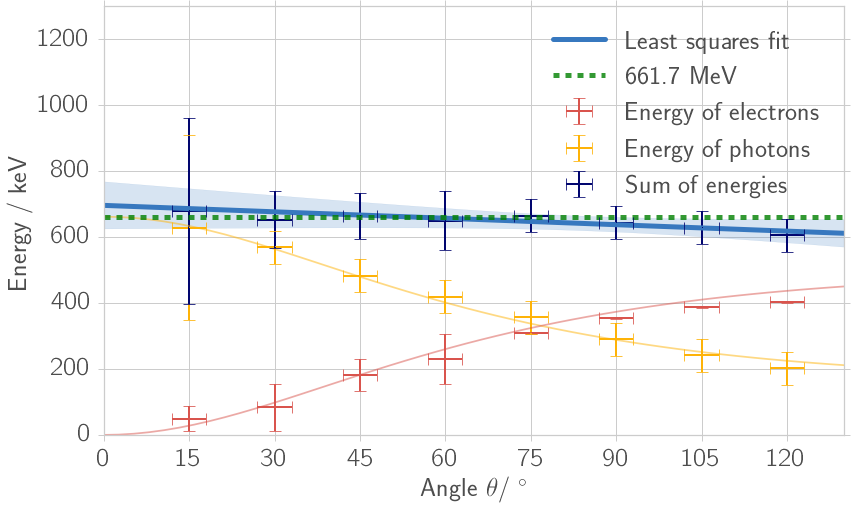

In [78]:
def height(channel, a,b):
    return a + b*channel

ps_cal = np.load(npy_dir + 'ps_calibration.npy')
na_cal = np.load(npy_dir + 'na_calibration.npy')


c_ps = np.array([i[1] for i in c_ps_filter[0:4]]+[i[1] for i in c_ps_gauss[4::]])

E_peaks_ps = ucarray([linear(ci, *ps_cal) for ci in c_ps])

E_offset = uc.ufloat(50,50)

E_peaks_na = ucarray([linear(16 * ci[1], *na_cal) for ci in c_na]) - E_offset
theta = theta_na
E_sum = E_peaks_ps + E_peaks_na


angle_error = 3

# Plotting
fig1, ax1 = plt.subplots(1, 1)
fixticks(ax1)
if not save_fig:
    fig1.suptitle('Energy conservation, all angles')
    
    
## E_electrons 
ax1.errorbar(theta_ps, nom(E_peaks_ps), \
             xerr=angle_error, yerr=sam(E_peaks_ps), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='Energy of electrons',color=colors[1])


# E_photons
ax1.errorbar(theta_na, nom(E_peaks_na), \
             xerr=angle_error, yerr=sam(E_peaks_na), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='Energy of photons',color=colors[3])


p0 = [700,0]

coeff, cov = curve_fit(height,theta, nom(E_sum), p0=p0,
                sigma=sam(E_sum), absolute_sigma=True)
coeff = uc.correlated_values(coeff, cov)

theta_fit = np.linspace(0,130)
fit = height(theta_fit,*coeff)


ax1.plot(theta_fit,nom(fit),color=colors[0],label="Least squares fit", linewidth = 5)



ax1.fill_between(theta_fit, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)


E_gamma = 662

ax1.plot(theta_fit,E_photon(theta_fit, E_gamma),color=colors[3],alpha=0.5)
ax1.plot(theta_fit,E_electron(theta_fit, E_gamma),color=colors[1],alpha=0.5)
ax1.plot(theta_fit,theta_fit*0+661.7,"--",color="green",label="661.7 MeV", linewidth = 5 ,alpha=0.8)

# sum
ax1.errorbar(theta, un.nominal_values(E_sum), \
             xerr=angle_error, yerr=un.std_devs(E_sum), \
             fmt=',', elinewidth=2.0, capsize=6.2, capthick=0.8, \
            label='Sum of energies',color=colors[8])


ax1.set_xlim(0, 130)
ax1.set_ylim(0,1300)
ax1.set_xlabel("Angle $\\theta$/ $^\circ$")
ax1.set_ylabel("Energy / keV")
ax1.legend(loc=1)
ax1.set_xticks(np.arange(0, 121, 15))
ax1.grid(True)
if save_fig:
    file_name = "energy_conservation"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


## presentation pic

'../figures/./compton_scatter.pdf'